In [0]:
!pip install transformers

     |████████████████████████████████| 501kB 7.1MB/s 
     |████████████████████████████████| 870kB 49.8MB/s 
     |████████████████████████████████| 3.7MB 39.9MB/s 
     |████████████████████████████████| 1.0MB 48.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=1125c8da50fb302245e9188dc71ef393fb265d3b24bc9604727451c99b621ad7
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import json
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sbn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, WeightedRandomSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForSequenceClassification,
    BertTokenizer,
    AlbertConfig,
    AlbertForSequenceClassification,
    AlbertTokenizer,
    get_linear_schedule_with_warmup,
)

from transformers import glue_processors as processors
from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_convert_examples_to_features as convert_examples_to_features

from transformers.data.processors import DataProcessor, InputExample, InputFeatures

In [0]:
class st10(DataProcessor):
    """Processor for the SST-2 data set (GLUE version)."""

    def __init__(self):
        self.sk10 = pd.read_pickle("/content/drive/My Drive/labelled_tweets.pkl")        

        self.seed = 2123921

        if DEBUG:
            self.sk10 = self.sk10.iloc[:1000]
        
        train, eval_ = train_test_split(self.sk10, random_state=self.seed, stratify=self.sk10.label)
        
        guid=0
        self.train = []
        for _, row in train.iterrows():
            self.train.append(
                InputExample(guid=guid, text_a=row.full_text, text_b=None, label=row.label)
            )
            guid += 1

        self.eval_ = []
        for _, row in eval_.iterrows():
            self.eval_.append(
                InputExample(guid=guid, text_a=row.full_text, text_b=None, label=row.label)
            )
            guid += 1


    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["sentence"].numpy().decode("utf-8"),
            None,
            str(tensor_dict["label"].numpy()),
        )

    def get_train_examples(self):
        """See base class."""
        return self.train

    def get_dev_examples(self):
        """See base class."""
        return self.eval_

    def get_labels(self):
        """See base class."""
        return ["negative", "neutral", "positive"]

In [0]:
def train(device, model, train_dataset, eval_dataset):
    num_train_samples_per_class = torch.tensor([744.0, 3105.0, 1139.0])
    weights = 1.0/num_train_samples_per_class
    labels = torch.tensor([d[3] for d in train_dataset])
    
    weights = weights[torch.tensor(labels)]

    train_batch_size = 8
    sampler = WeightedRandomSampler(weights, len(weights))
    train_dataloader = DataLoader(train_dataset, sampler=sampler, batch_size=train_batch_size)

    num_train_epochs = 5
    max_steps = -1

    weight_decay = 0.0
    learning_rate = 5e-5
    adam_epsilon = 1e-8
    warmup_steps = 0
    max_grad_norm = 1.0

    t_total = len(train_dataloader) * num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total
    )

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0

    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(num_train_epochs), desc="Epoch",
    )

    for _ in train_iterator:

        eval_result = evaluate(device, model, eval_dataset)
        print("eval_result: {}".format(eval_result))

        epoch_iterator = tqdm(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):

            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
            
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            loss.backward()

            tr_loss += loss.item()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            model.zero_grad()
            global_step += 1


            if max_steps > 0 and global_step > max_steps:
                epoch_iterator.close()
                break
        if max_steps > 0 and global_step > max_steps:
            train_iterator.close()
            break

    return global_step, tr_loss / global_step


def load_and_cache_examples(processor, tokenizer, label_list, output_mode, max_seq_length, evaluate=False):
    
    examples = (
        processor.get_dev_examples() if evaluate else processor.get_train_examples()
    )

    features = convert_examples_to_features(
        examples,
        tokenizer,
        label_list=label_list,
        max_length=max_seq_length,
        output_mode=output_mode,
        pad_on_left=False,
        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
        pad_token_segment_id=0,
    )

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
    return dataset

def evaluate(device, model, eval_dataset):

    eval_batch_size = 8

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)
    
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3],
            }
            outputs = model(**inputs)

            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=1)
    print(classification_report(out_label_ids, preds))
    return (preds == out_label_ids).mean()

In [0]:
def predict(input_text, tokenizer, model, device):


    label_list = ["negative", "neutral", "positive"]
    output_mode = "classification"
    max_len = 40

    examples = []
    tweet_ids = []
    guid = 0
    
    for text in input_text:

        examples.append(
                        InputExample(guid="pred-{}".format(guid), text_a=text, text_b=None, label="neutral")
                    )
        guid += 1
    
    features = convert_examples_to_features(
        examples,
        tokenizer,
        label_list=label_list,
        max_length=max_len,
        output_mode=output_mode,
        pad_on_left=False,
        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
        pad_token_segment_id=0,
    )

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

    pred_batch_size = 8

    pred_sampler = SequentialSampler(dataset)
    pred_dataloader = DataLoader(dataset, sampler=pred_sampler, batch_size=pred_batch_size)
    
    preds = []
    out_label_ids = None
    for batch in tqdm(pred_dataloader, desc="Prediction"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3],
            }
            outputs = model(**inputs)
            preds += outputs[1].argmax(axis=1).detach().tolist()

    for ilayer in range(12):
      print("Layer: ",ilayer)
      attention = outputs[2][ilayer][0][0]
      fig, ax = plt.subplots(figsize=(2,10))         # Sample figsize in inches
      tokens = tokenizer.convert_ids_to_tokens(batch[0][0])
      cutoff = tokens.index("[PAD]")
      tokens = np.asarray(tokens).reshape((40,1))[:cutoff]
      print("1.Zeile")
      sbn.heatmap(attention[0,:cutoff,None].cpu(),annot=tokens,fmt='',ax=ax)
      ax.set_yticklabels(tokens, rotation=0)
      plt.show()
      print("1.Spalte")
      fig, ax = plt.subplots(figsize=(2,10))         # Sample figsize in inches
      sbn.heatmap(attention[:cutoff,0,None].cpu(),annot=tokens,fmt='',ax=ax)
      ax.set_yticklabels(tokens, rotation=0)
      plt.show()


    return preds

In [0]:
DEBUG = False


def main():

    device = torch.device("cuda:0")
    processor = st10()
    output_mode = "classification"
    label_list = ["negative", "neutral", "positive"]
    num_labels = len(label_list)
    task_name = "senti"
    output_dir = "finetuned_model"
    max_len = 40
    #model_name = "albert-xxlarge-v2"
    #config_class, model_class, tokenizer_class = AlbertConfig, AlbertForSequenceClassification, AlbertTokenizer

    model_name =  "dbmdz/bert-base-german-cased"
    config_class, model_class, tokenizer_class = BertConfig, BertForSequenceClassification, BertTokenizer
    
    config = config_class.from_pretrained(
        model_name,
        num_labels=num_labels,
        finetuning_task=task_name,
        id2label={i:k for i,k in enumerate(label_list)},
        label2id={k:i for i,k in enumerate(label_list)},
        max_length=max_len,
        output_attentions=True
    )
    tokenizer = tokenizer_class.from_pretrained(
        model_name,
        do_lower_case=False
    )
    model = model_class.from_pretrained(
        model_name,
        config=config
    )

    model.to(device)

    train_dataset = load_and_cache_examples(processor, tokenizer, label_list, output_mode, max_len, evaluate=False)
    eval_dataset = load_and_cache_examples(processor, tokenizer, label_list, output_mode, max_len, evaluate=True)
    
    
    
    global_step, tr_loss = train(device, model, train_dataset, eval_dataset)
    print(" global_step = %s, average loss = %s", global_step, tr_loss)
    result = evaluate(device, model, eval_dataset)
    print("evaluation accuracy: {}".format(result))

    #model_to_save = (
    #    model.module if hasattr(model, "module") else model
    #) 
    #model_to_save.save_pretrained(output_dir)
    #tokenizer.save_pretrained(output_dir)

    import tarfile
    tarfile_ = tarfile.open("/content/drive/My Drive/thueringen_unique.tar.gz")
    sub_file = 'thueringen_unique/thueringen_unique.json'
    if DEBUG:
        tarfile_ = tarfile.open("/content/drive/My Drive/thueringen_small.tar.gz")
        sub_file = 'thueringen_small/thueringen2_noRT.json'
    

    def get_batch(f, batch_size=8):
        c_batch = []
        try:
            for row in f:
                tweet = json.loads(row)
                if "retweeted_status" not in tweet:
                    c_batch.append(tweet)
                if len(c_batch) == batch_size:
                    yield c_batch
                    c_batch = []
        except StopIteration:
            yield c_batch

    examples = []
    tweet_ids = []
    guid = 0
    
    with tarfile_.extractfile(sub_file) as fin:
        for batch in tqdm(get_batch(fin),desc="load thueringen twitter data"):

            for sample in batch:
                tweet_ids.append(sample["id_str"])
                examples.append(
                    InputExample(guid="pred-{}".format(guid), text_a=sample["full_text"], text_b=None, label="neutral")
                )
                guid += 1
    
    features = convert_examples_to_features(
        examples,
        tokenizer,
        label_list=label_list,
        max_length=max_len,
        output_mode=output_mode,
        pad_on_left=False,
        pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
        pad_token_segment_id=0,
    )

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

    pred_batch_size = 8

    pred_sampler = SequentialSampler(dataset)
    pred_dataloader = DataLoader(dataset, sampler=pred_sampler, batch_size=pred_batch_size)
    
    preds = []
    out_label_ids = None
    for batch in tqdm(pred_dataloader, desc="Prediction"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3],
            }
            outputs = model(**inputs)
            preds += outputs[1].argmax(axis=1).detach().tolist()

    df = pd.DataFrame.from_dict({
        "tweet_ids" : tweet_ids,
        "sentiments": list(map(lambda x: label_list[x],  preds))
    })  

    return df, model, tokenizer, device

df, model, tokenizer, device = main()
df.to_pickle("thueringen_with_sentiment.pkl")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


              precision    recall  f1-score   support

           0       0.36      0.02      0.04       248
           1       0.62      0.92      0.74      1035
           2       0.22      0.06      0.10       380

    accuracy                           0.59      1663
   macro avg       0.40      0.34      0.29      1663
weighted avg       0.49      0.59      0.49      1663

eval_result: 0.5929043896572459


Epoch:  20%|██        | 1/5 [01:10<04:43, 70.99s/it]


              precision    recall  f1-score   support

           0       0.52      0.50      0.51       248
           1       0.88      0.73      0.80      1035
           2       0.53      0.79      0.63       380

    accuracy                           0.71      1663
   macro avg       0.64      0.67      0.65      1663
weighted avg       0.75      0.71      0.72      1663

eval_result: 0.7101623571858088


Epoch:  40%|████      | 2/5 [02:21<03:32, 70.91s/it]


              precision    recall  f1-score   support

           0       0.59      0.38      0.46       248
           1       0.81      0.87      0.84      1035
           2       0.67      0.68      0.67       380

    accuracy                           0.76      1663
   macro avg       0.69      0.64      0.66      1663
weighted avg       0.74      0.76      0.75      1663

eval_result: 0.7552615754660252


Epoch:  60%|██████    | 3/5 [03:32<02:21, 70.90s/it]


              precision    recall  f1-score   support

           0       0.53      0.49      0.51       248
           1       0.83      0.86      0.84      1035
           2       0.69      0.67      0.68       380

    accuracy                           0.76      1663
   macro avg       0.68      0.67      0.68      1663
weighted avg       0.75      0.76      0.76      1663

eval_result: 0.7588695129284426


Epoch:  80%|████████  | 4/5 [04:41<01:10, 70.41s/it]


              precision    recall  f1-score   support

           0       0.54      0.48      0.51       248
           1       0.84      0.83      0.84      1035
           2       0.65      0.71      0.68       380

    accuracy                           0.75      1663
   macro avg       0.68      0.67      0.67      1663
weighted avg       0.75      0.75      0.75      1663

eval_result: 0.7528562838244137


Epoch: 100%|██████████| 5/5 [05:50<00:00, 69.79s/it]


 global_step = %s, average loss = %s 3120 0.30305306333809706



              precision    recall  f1-score   support

           0       0.62      0.38      0.47       248
           1       0.81      0.89      0.85      1035
           2       0.69      0.69      0.69       380

    accuracy                           0.76      1663
   macro avg       0.71      0.65      0.67      1663
weighted avg       0.75      0.76      0.75      1663

evaluation accuracy: 0.7648827420324714



Layer:  0
1.Zeile


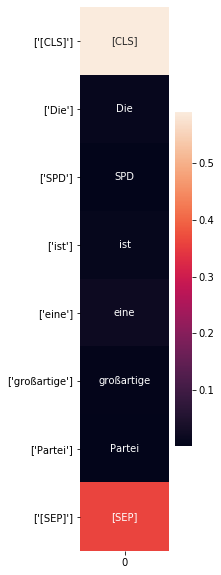

1.Spalte


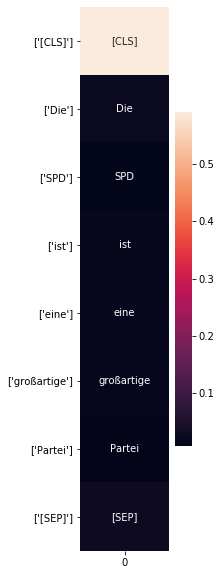

Layer:  1
1.Zeile


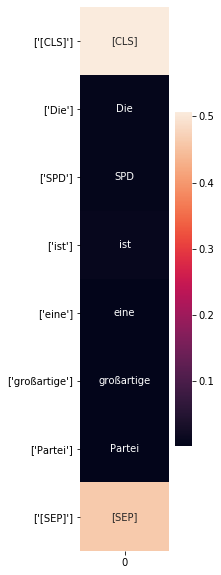

1.Spalte


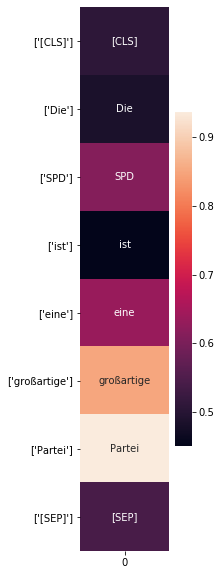

Layer:  2
1.Zeile


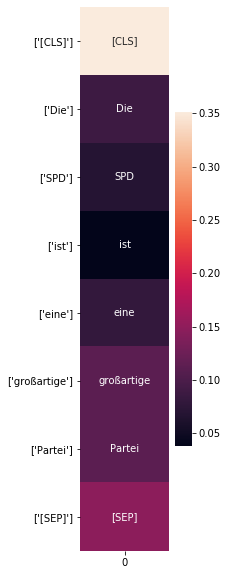

1.Spalte


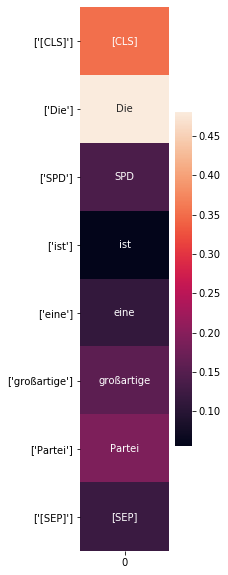

Layer:  3
1.Zeile


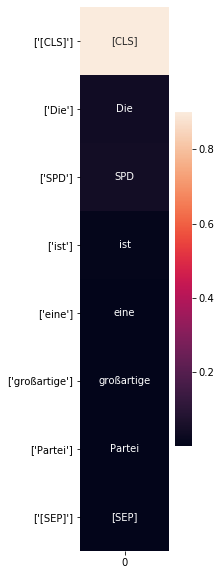

1.Spalte


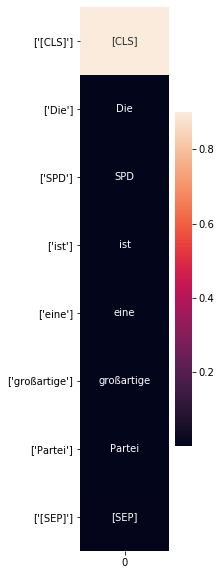

Layer:  4
1.Zeile


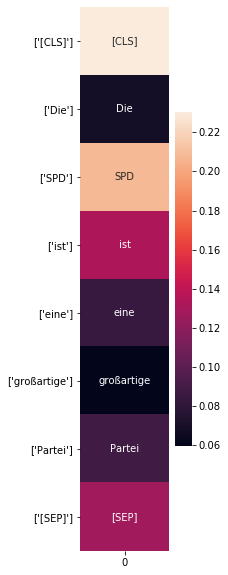

1.Spalte


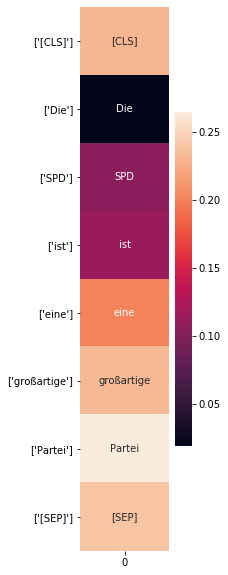

Layer:  5
1.Zeile


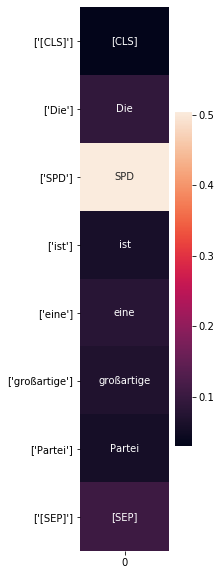

1.Spalte


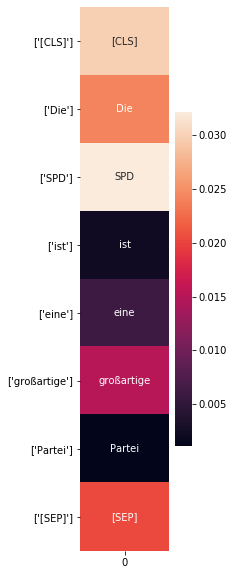

Layer:  6
1.Zeile


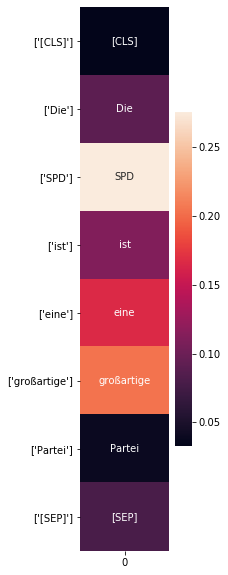

1.Spalte


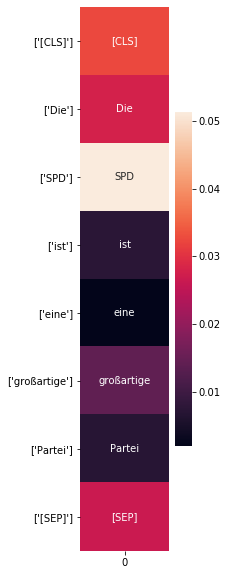

Layer:  7
1.Zeile


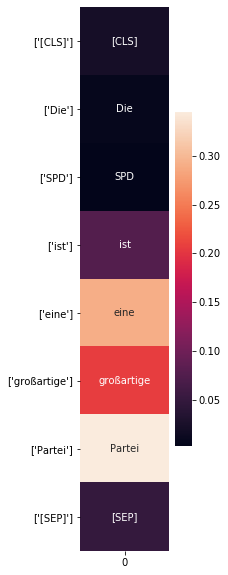

1.Spalte


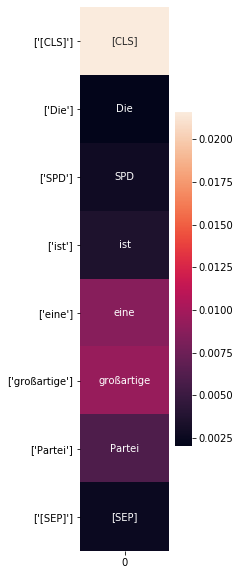

Layer:  8
1.Zeile


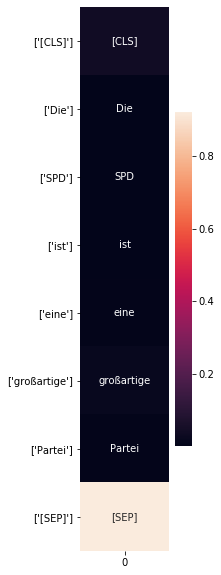

1.Spalte


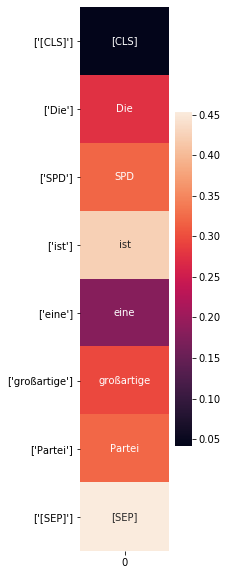

Layer:  9
1.Zeile


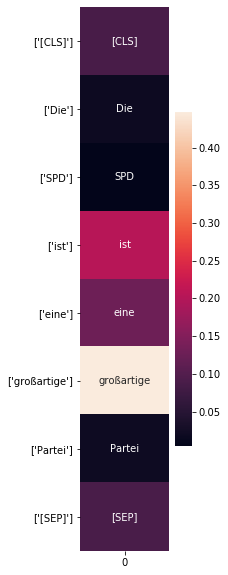

1.Spalte


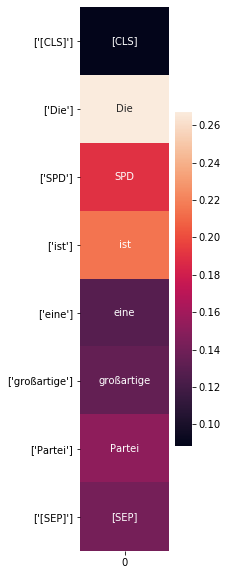

Layer:  10
1.Zeile


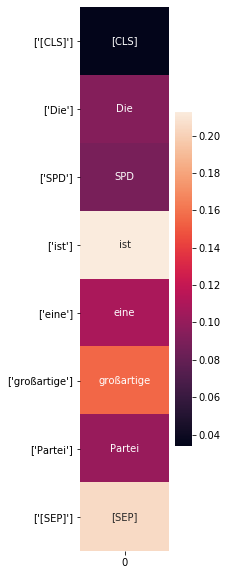

1.Spalte


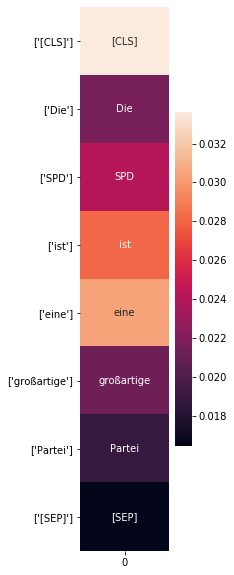

Layer:  11
1.Zeile


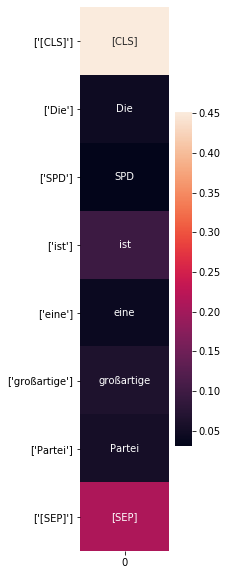

1.Spalte


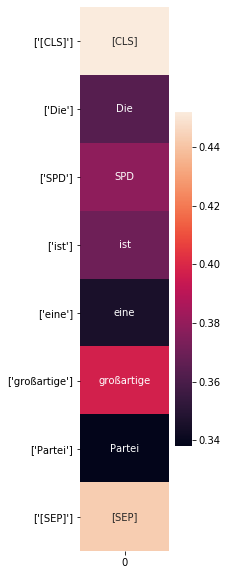

positive


In [0]:
label_list = ["negative", "neutral", "positive"]
labels = predict(["Die SPD ist eine großartige Partei"], tokenizer, model, device)
print(label_list[labels[0]])

# labels = predict(["Die SPD ist eine nervige Partei"], tokenizer, model, device)
# print(label_list[labels[0]])

# labels = predict(["Die Wahl von Kemmerich in Thueringen war ein Desaster"], tokenizer, model, device)
# print(label_list[labels[0]])

In [0]:
text = np.asarray([['a', 'b', 'c', 'd', 'e', 'f'], ['g', 'h', 'i', 'j', 'k', 'l'], ['m', 'n', 'o', 'p', 'q', 'r'], ['s', 't', 'u', 'v', 'w', 'x']])
type(text)
data = np.random.rand(4, 6)
labels = (np.asarray(["{0}\n{1:.2f}".format(text,data) for text, data in zip(text.flatten(), data.flatten())])).reshape(4,6)
print(type(labels))
print(labels[0,0].shape)
print(type(labels[0,0]))


<class 'numpy.ndarray'>
()
<class 'numpy.str_'>


In [0]:
df.groupby("sentiments").count()

,tweet_ids
sentiments,
negative,54
neutral,761
positive,49
